In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r '/content/drive/MyDrive/AADNN/HW#5/Homework5_dataset.zip' '/content'

In [ ]:
!unzip -qq '/content/Homework5_dataset'

In [ ]:
!pip install efficientnet_pytorch --quiet

  Preparing metadata (setup.py) ... done


#Utils

In [ ]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import glob
import random
from  matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from efficientnet_pytorch import EfficientNet
import numpy

In [ ]:
def getTransforms():
    return  transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

### TOP10

In [ ]:
def top_10(person_loader, single_images):
  transforms = getTransforms()
  distance = numpy.array([])

  path = single_images[5]
  anchor = Image.open(path).convert("RGB") # Reading image
  label = path.split("/")[-1][:4]

  plt.imshow(anchor)
  plt.show()
  anchor = transforms(anchor).unsqueeze(dim=0).to(device)

  p_loop = tqdm(enumerate(person_loader, 1), total=len(person_loader),  position=0, leave=True)
  for _, batch in p_loop:
      optimizer.zero_grad()
      img1 = batch.to(device)
      output1, output2 = model(anchor, img1)
      euclidean_distance = nn.functional.pairwise_distance(output1, output2, keepdim=True).detach().cpu().numpy()
      distance = numpy.append(distance, euclidean_distance)

  top10_index = sorted(range(len(distance)), key=lambda k: distance[k])[:10]

  fig, axs = plt.subplots(2, 5, figsize=(15, 6))
  for i, img_idx in enumerate(top10_index):
      img = Image.open(single_images[img_idx]).convert("RGB")
      img = numpy.array(img)
      row = i // 5
      col = i % 5
      axs[row, col].imshow(img)
      axs[row, col].axis('off')

  plt.tight_layout()
  plt.show()

### ROC

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

def plot_roc_curve(model, loader, typeL):

    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    similarities = []
    ground_truth = []
    with torch.no_grad():
        for idx, batch in enumerate(loader):
            img1, img2, label = batch
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)
            output1, output2 = model(img1, img2)
            similarity = F.cosine_similarity(output1, output2)
            similarities.extend(similarity.cpu().numpy())
            ground_truth.extend(label.cpu().numpy())

    fpr, tpr, thresholds = roc_curve(ground_truth, similarities)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic for ' + typeL)
    plt.legend(loc="lower right")
    plt.show()
    return fpr, tpr, thresholds

In [ ]:
def nearest_fnr(input, value):
    input = numpy.asarray(input)
    idx = (numpy.abs(input - value)).argmin()
    return input[idx], idx

#Dataset

#### Read all image path

In [ ]:
def read_images(train_split=0.8):
    DIR_ = "/content/Homework5_dataset"
    images = []
    images += glob.glob(DIR_ + '/*.jpg')
    return images

In [ ]:
def create_dictinary(img_list):
  classes = dict()
  for pth in img_list:
    key = pth.split("/")[-1][:4]
    if key not in classes.keys():
      classes[key] = []
    classes[key].append(pth)
  print(classes.keys())
  print(len(classes.keys()))
  return classes

#### generate pairs

In [ ]:
def generate_pairs(items, num_pairs):
    pairs = set()
    for _ in range(num_pairs):
        anchor = numpy.random.choice(img_list)
        classAnchor = anchor.split("/")[-1][:4]
        same_anchor = dict_paths[classAnchor]
        diff_sample = []
        for key in items:
          if key != classAnchor:
            diff_sample+= dict_paths[key]
        if random.random() < 0.5:
            # Create a positive pair
            positive = numpy.random.choice(same_anchor)
            pairs.add((anchor, positive))
        else:
            # Create a negative pair
            negetive = numpy.random.choice(diff_sample)
            pairs.add((anchor, negetive))
    return list(pairs)

#### single Person dataset

In [ ]:
class PersonDataset(Dataset):
    def __init__(self, images):
        super(PersonDataset, self).__init__()
        self.images = images
        self.transforms = getTransforms()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        images_path = self.images[index]
        image1 = Image.open(images_path).convert("RGB") # Reading image

        # Applying transforms on image
        image1 = self.transforms(image1)

        return image1

In [ ]:
def single_dataset(pairs_dataset):
  image_data = set()
  for p in pairs_dataset:
    image_data.add(p[0])
  return list(image_data)

#### Pair Dataset

In [ ]:
class SiameseDataset(Dataset):
    def __init__(self, pairs_list):
        super(SiameseDataset, self).__init__()
        self.pairs_list = pairs_list
        self.transforms = getTransforms()

    def __len__(self):
        return len(self.pairs_list)

    def __getitem__(self, index):
        pairs_path = self.pairs_list[index]
        img1_path = pairs_path[0]
        img2_path = pairs_path[1]
        image1 = Image.open(img1_path).convert("RGB") # Reading image
        image2 = Image.open(img2_path).convert("RGB") # Reading image

        # Retriving class label
        label1 = img1_path.split("/")[-1][:4]
        label2 = img2_path.split("/")[-1][:4]

        label = 1 if label1 == label2 else 0

        # Applying transforms on image
        image1 = self.transforms(image1)
        image2 = self.transforms(image2)

        return image1, image2, label

## Generate Dataset

In [ ]:
img_list = read_images()

In [ ]:
dict_paths = create_dictinary(img_list)

dict_keys(['0444', '0711', '1253', '0669', '1489', '1158', '0202', '0243', '1297', '0459', '0837', '0816', '0077', '0132', '0160', '1346', '0195', '1339', '0030', '1289', '0321', '0566', '1421', '0123', '0673', '0010', '1260', '0221', '0738', '0734', '1385', '0755', '0261', '0647', '0879', '0115', '0107', '1364', '0760', '0666', '0653', '0642', '0399', '0999', '0748', '0629', '1030', '0611', '0681', '0992', '0111', '0446', '0952', '1197', '0081', '0027', '0742', '0943', '0707', '0333', '0563', '0636', '0565', '0605', '0557', '1076', '1244', '0803', '0885', '0121', '0158', '0820', '1238', '1097', '0125', '0352', '1071', '0766', '0519', '0496', '1088', '0193', '0314', '0264', '0105', '0667', '0108', '0761', '0413', '0967', '1165', '1409', '0002', '0268', '0810', '1500', '0754', '1363', '0303', '0765', '1296', '0613', '0986', '0641', '1152', '1017', '0178', '1453', '0872', '1177', '0842', '1467', '1430', '0023', '0726', '1327', '0788', '0589', '1066', '0209', '0347', '1475', '1232', '1007

In [ ]:
from random import sample
train_dict_paths = sample(list(dict_paths.keys()), 600)
val_dict_paths = [key for key in list(dict_paths.keys()) if key not in train_dict_paths]

In [ ]:
train_pairs = generate_pairs(train_dict_paths, 10000)
val_pairs = generate_pairs(val_dict_paths, 1000)

In [ ]:
train_single_images = single_dataset(train_pairs)
train_person_dataset = PersonDataset(train_single_images)
train_person_loader = DataLoader(train_person_dataset, batch_size=32, shuffle=False)

val_single_images = single_dataset(val_pairs)
val_person_dataset = PersonDataset(val_single_images)
val_person_loader = DataLoader(val_person_dataset, batch_size=32, shuffle=False)

In [ ]:
train_dataset = SiameseDataset(train_pairs)
val_dataset = SiameseDataset(val_pairs)

# Dataloader

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Network

In [ ]:
class SiameseEfficientNet(nn.Module):
    def __init__(self):
        super(SiameseEfficientNet, self).__init__()
        self.efficientnet = EfficientNet.from_pretrained('efficientnet-b0')
        self.sigmoid = nn.Sigmoid()

    def forward_one(self, x):
        x = self.efficientnet.extract_features(x)
        x = self.efficientnet._avg_pooling(x)
        x = x.view(x.size()[0], -1)  # Flatten the output
        return x

    def forward(self, input1, input2):
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        return output1, output2

# Loss

In [ ]:
class ContrastiveLoss(nn.Module):
    def __init__(self):
        super(ContrastiveLoss, self).__init__()
        self.margin = 1.0

    def forward(self, output1, output2, label):
        _distance = nn.functional.pairwise_distance(output1, output2, keepdim=True)
        loss =  torch.mean(
            (1-label) * torch.pow(_distance, 2) + (label) * torch.pow(torch.clamp(self.margin - _distance, min=0.0), 2)
        )
        return loss

# Training

In [ ]:
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SiameseEfficientNet().to(device)
criterion = ContrastiveLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
lr_scheduler = StepLR(optimizer, step_size=8, gamma=0.1)

epochs = 20

train_loss = []
val_loss = []

# Training loop
for epoch in tqdm(range(1, epochs + 1)):
    model.train()
    loop_train = tqdm(enumerate(train_loader, 1), total=len(train_loader), desc="train", position=0, leave=True)
    avg_train_loss = 0

    for idx, batch in loop_train:
        img1, img2, labels = batch
        img1, img2, labels = img1.to(device), img2.to(device), torch.Tensor(labels).to(device)
        optimizer.zero_grad()
        output1, output2 = model(img1, img2)
        loss = criterion(output1, output2, labels)
        avg_train_loss+=loss.item()
        loss.backward()
        optimizer.step()

        loop_train.set_description(f"Train - iteration : {epoch}")
        loop_train.set_postfix(
                avg_train_loss="{:.4f}".format(avg_train_loss/idx),
                refresh=True,
            )
    train_loss.append(avg_train_loss/idx)

    model.eval()
    loop_val = tqdm(enumerate(val_loader, 1), total=len(val_loader), desc="val", position=0, leave=True)
    avg_val_loss = 0

    for idx, batch in loop_val:
        optimizer.zero_grad()
        img1, img2, labels = batch
        img1, img2, labels = img1.to(device), img2.to(device), torch.Tensor(labels).to(device)
        output1, output2 = model(img1, img2)
        loss = criterion(output1, output2, labels)
        avg_val_loss+=loss.item()

        loop_val.set_description(f"Val - iteration : {epoch}")
        loop_val.set_postfix(
                avg_val_loss="{:.4f}".format(avg_val_loss/idx),
                refresh=True,
            )
    val_loss.append(avg_val_loss/idx)
    lr_scheduler.step()


Loaded pretrained weights for efficientnet-b0


100%|██████████| 20/20 [15:41<00:00, 47.09s/it]


# Loss Plot

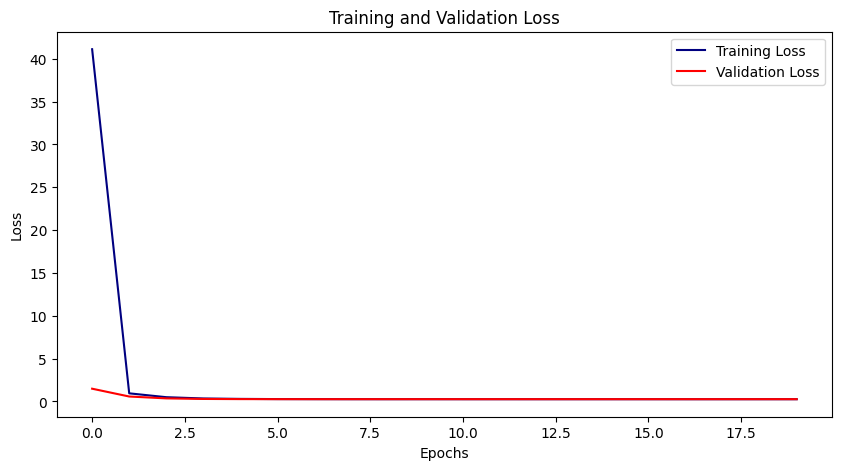

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss', color='navy')
plt.plot(val_loss, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Top 10

## train top 10

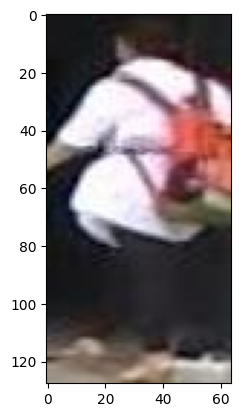

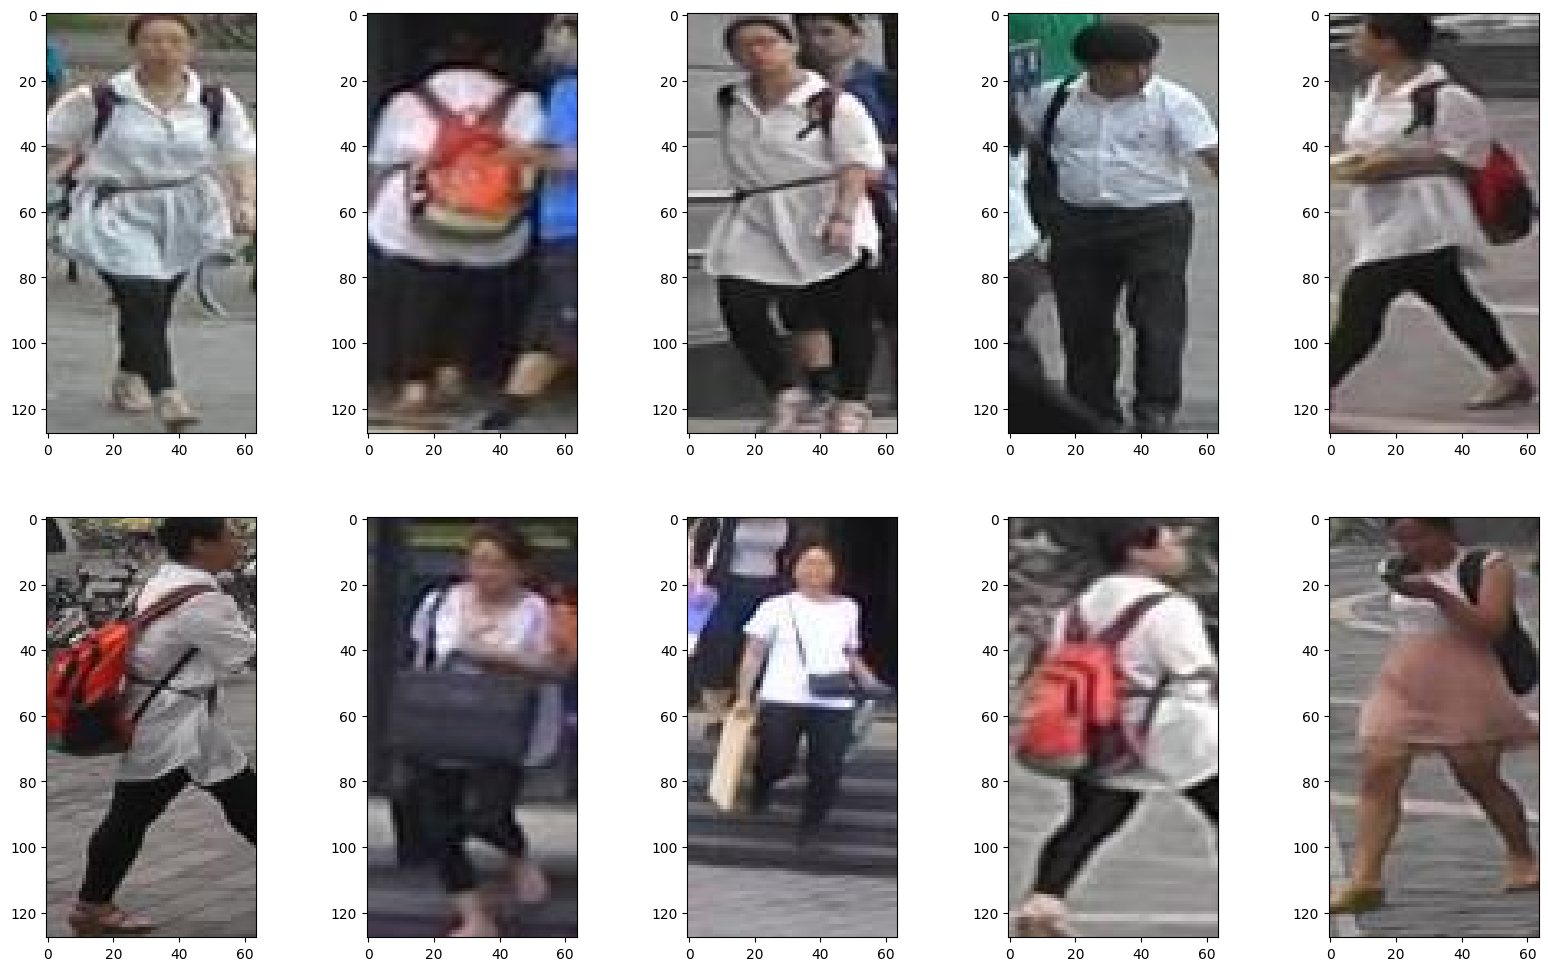

In [ ]:
top_10(train_person_loader, train_single_images)

## test top 10

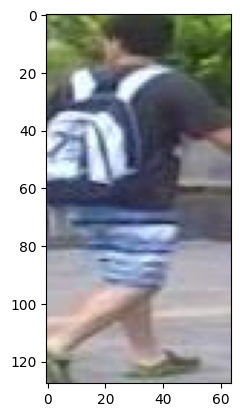

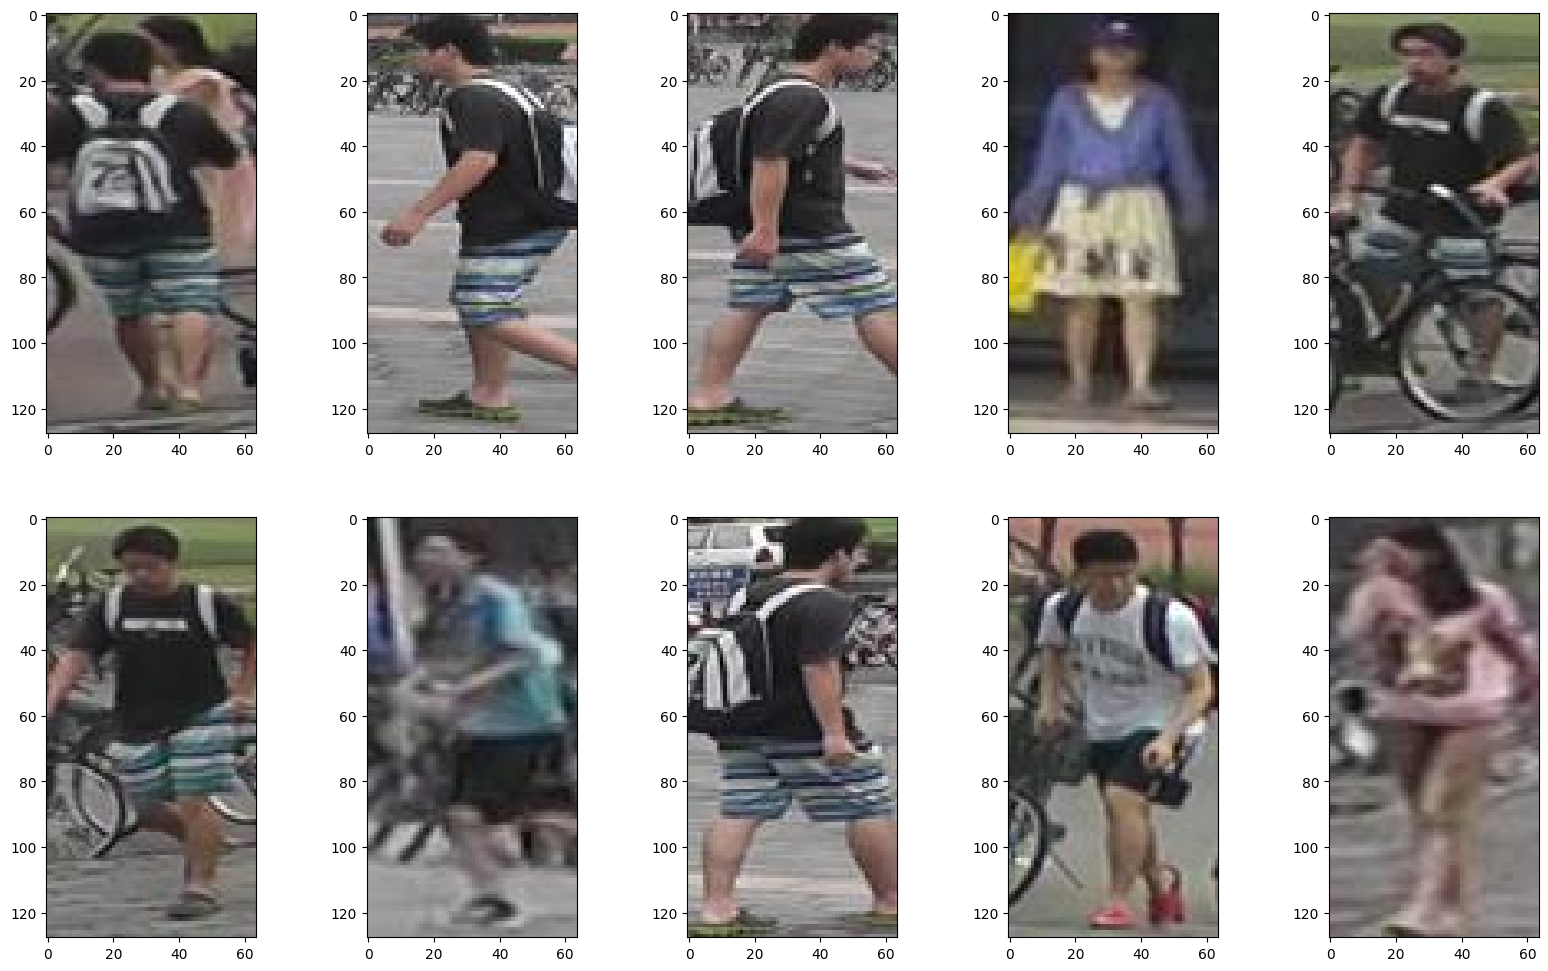

In [ ]:
top_10(val_person_loader, val_single_images)

# Roc

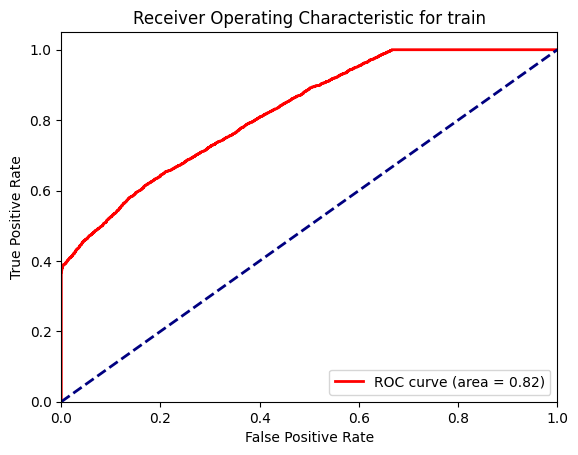

In [ ]:
train_fpr, train_tpr, train_thresholds = plot_roc_curve(model, train_loader, "train")

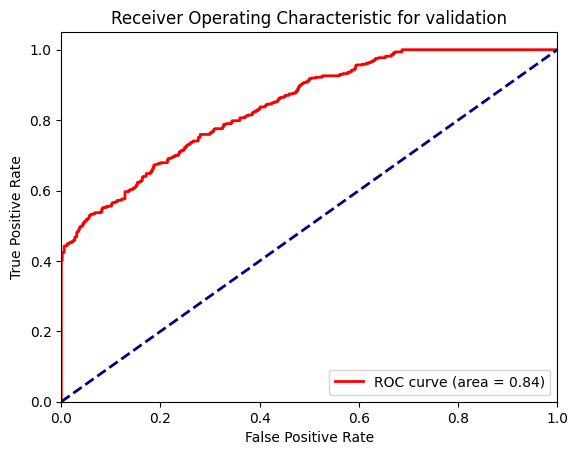

In [ ]:
val_fpr, val_tpr, val_thresholds = plot_roc_curve(model, val_loader, "validation")

#TPR

### train

In [ ]:
thresholds = [0.5, 0.1, 0.01, 0.001]

# Report tpr for desired fpr values
for thr in thresholds:
    _fpr, idx = nearest_fnr(train_fpr, thr)
    _tpr = train_tpr[idx]
    print(f"Best False Negetive Rate(FPR) to {thr}: {_fpr:.4f}, True Positive Rate(FPR): {_tpr:.4f}")

Best False Negetive Rate(FPR) to 0.5: 0.4994, True Positive Rate(FPR): 0.8860
Best False Negetive Rate(FPR) to 0.1: 0.1000, True Positive Rate(FPR): 0.5262
Best False Negetive Rate(FPR) to 0.01: 0.0100, True Positive Rate(FPR): 0.4028
Best False Negetive Rate(FPR) to 0.001: 0.0010, True Positive Rate(FPR): 0.3795


### validation

In [ ]:
thresholds = [0.5, 0.1, 0.01, 0.001]

# Report tpr for desired fpr values
for thr in thresholds:
    _fpr, idx = nearest_fnr(val_fpr, thr)
    _tpr = val_tpr[idx]
    print(f"Best False Negetive Rate(FPR) to {thr}: {_fpr:.4f}, True Positive Rate(FPR): {_tpr:.4f}")

Best False Negetive Rate(FPR) to 0.5: 0.4960, True Positive Rate(FPR): 0.8855
Best False Negetive Rate(FPR) to 0.1: 0.0980, True Positive Rate(FPR): 0.5241
Best False Negetive Rate(FPR) to 0.01: 0.0100, True Positive Rate(FPR): 0.3996
Best False Negetive Rate(FPR) to 0.001: 0.0000, True Positive Rate(FPR): 0.0000


#Margin

## margin:10

In [ ]:
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SiameseEfficientNet().to(device)
criterion = ContrastiveLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
lr_scheduler = StepLR(optimizer, step_size=8, gamma=0.1)

epochs = 20

train_loss = []
val_loss = []

# Training loop
for epoch in tqdm(range(1, epochs + 1)):
    model.train()
    loop_train = tqdm(enumerate(train_loader, 1), total=len(train_loader), desc="train", position=0, leave=True)
    avg_train_loss = 0

    for idx, batch in loop_train:
        img1, img2, labels = batch
        img1, img2, labels = img1.to(device), img2.to(device), torch.Tensor(labels).to(device)
        optimizer.zero_grad()
        output1, output2 = model(img1, img2)
        loss = criterion(output1, output2, labels)
        avg_train_loss+=loss.item()
        loss.backward()
        optimizer.step()

        loop_train.set_description(f"Train - iteration : {epoch}")
        loop_train.set_postfix(
                avg_train_loss="{:.4f}".format(avg_train_loss/idx),
                refresh=True,
            )
    train_loss.append(avg_train_loss/idx)

    model.eval()
    loop_val = tqdm(enumerate(val_loader, 1), total=len(val_loader), desc="val", position=0, leave=True)
    avg_val_loss = 0

    for idx, batch in loop_val:
        optimizer.zero_grad()
        img1, img2, labels = batch
        img1, img2, labels = img1.to(device), img2.to(device), torch.Tensor(labels).to(device)
        output1, output2 = model(img1, img2)
        loss = criterion(output1, output2, labels)
        avg_val_loss+=loss.item()

        loop_val.set_description(f"Val - iteration : {epoch}")
        loop_val.set_postfix(
                avg_val_loss="{:.4f}".format(avg_val_loss/idx),
                refresh=True,
            )
    val_loss.append(avg_val_loss/idx)
    lr_scheduler.step()



# Save or use the trained model as needed

Loaded pretrained weights for efficientnet-b0


100%|██████████| 20/20 [15:41<00:00, 47.09s/it]


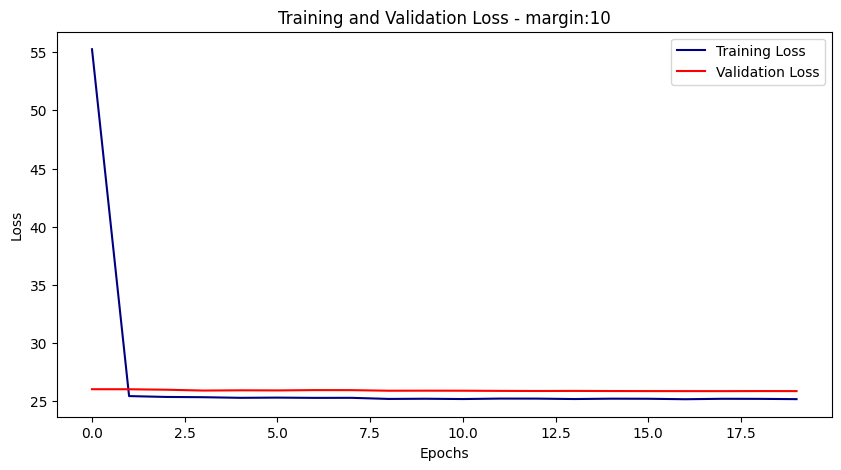

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss', color='navy')
plt.plot(val_loss, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss - margin:10')
plt.legend()
plt.show()

### Roc

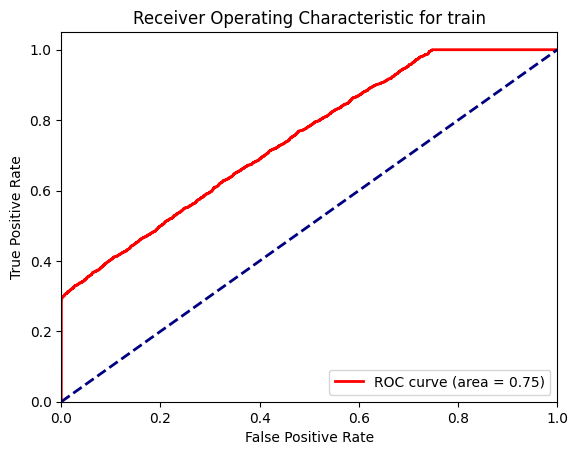

In [ ]:
train_fpr, train_tpr, train_thresholds = plot_roc_curve(model, train_loader, "train")

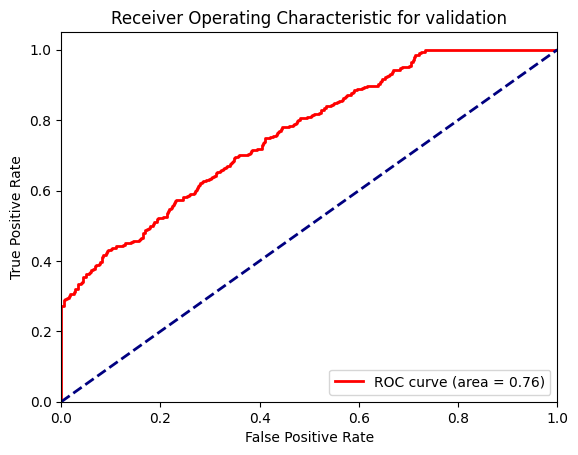

In [ ]:
val_fpr, val_tpr, val_thresholds = plot_roc_curve(model, val_loader, "validation")

####TPR

##### train

In [ ]:
thresholds = [0.5, 0.1, 0.01, 0.001]

# Report tpr for desired fpr values
for thr in thresholds:
    _fpr, idx = nearest_fnr(train_fpr, thr)
    _tpr = train_tpr[idx]
    print(f"Best False Negetive Rate(FPR) to {thr}: {_fpr:.4f}, True Positive Rate(FPR): {_tpr:.4f}")

Best False Negetive Rate(FPR) to 0.5: 0.5002, True Positive Rate(FPR): 0.7825
Best False Negetive Rate(FPR) to 0.1: 0.0998, True Positive Rate(FPR): 0.4038
Best False Negetive Rate(FPR) to 0.01: 0.0100, True Positive Rate(FPR): 0.3070
Best False Negetive Rate(FPR) to 0.001: 0.0010, True Positive Rate(FPR): 0.2938


##### validation

In [ ]:
thresholds = [0.5, 0.1, 0.01, 0.001]

# Report tpr for desired fpr values
for thr in thresholds:
    _fpr, idx = nearest_fnr(val_fpr, thr)
    _tpr = val_tpr[idx]
    print(f"Best False Negetive Rate(FPR) to {thr}: {_fpr:.4f}, True Positive Rate(FPR): {_tpr:.4f}")

Best False Negetive Rate(FPR) to 0.5: 0.4960, True Positive Rate(FPR): 0.8072
Best False Negetive Rate(FPR) to 0.1: 0.1000, True Positive Rate(FPR): 0.4317
Best False Negetive Rate(FPR) to 0.01: 0.0100, True Positive Rate(FPR): 0.2912
Best False Negetive Rate(FPR) to 0.001: 0.0000, True Positive Rate(FPR): 0.0000


##### Test

In [ ]:
thresholds = [0.5, 0.1, 0.01, 0.001]

# Report tpr for desired fpr values
for thr in thresholds:
    _fpr, idx = nearest_fnr(test_fpr, thr)
    _tpr = test_tpr[idx]
    print(f"Best False Negetive Rate(FPR) to {thr}: {_fpr:.4f}, True Positive Rate(FPR): {_tpr:.4f}")

Best False Negetive Rate(FPR) to 0.5: 0.5020, True Positive Rate(FPR): 0.8024
Best False Negetive Rate(FPR) to 0.1: 0.0992, True Positive Rate(FPR): 0.4644
Best False Negetive Rate(FPR) to 0.01: 0.0081, True Positive Rate(FPR): 0.2984
Best False Negetive Rate(FPR) to 0.001: 0.0000, True Positive Rate(FPR): 0.0000


## margin:0.1

In [ ]:
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SiameseEfficientNet().to(device)
criterion = ContrastiveLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
lr_scheduler = StepLR(optimizer, step_size=8, gamma=0.1)

epochs = 20

train_loss = []
val_loss = []

# Training loop
for epoch in tqdm(range(1, epochs + 1)):
    model.train()
    loop_train = tqdm(enumerate(train_loader, 1), total=len(train_loader), desc="train", position=0, leave=True)
    avg_train_loss = 0

    for idx, batch in loop_train:
        img1, img2, labels = batch
        img1, img2, labels = img1.to(device), img2.to(device), torch.Tensor(labels).to(device)
        optimizer.zero_grad()
        output1, output2 = model(img1, img2)
        loss = criterion(output1, output2, labels)
        avg_train_loss+=loss.item()
        loss.backward()
        optimizer.step()

        loop_train.set_description(f"Train - iteration : {epoch}")
        loop_train.set_postfix(
                avg_train_loss="{:.4f}".format(avg_train_loss/idx),
                refresh=True,
            )
    train_loss.append(avg_train_loss/idx)

    model.eval()
    loop_val = tqdm(enumerate(val_loader, 1), total=len(val_loader), desc="val", position=0, leave=True)
    avg_val_loss = 0

    for idx, batch in loop_val:
        optimizer.zero_grad()
        img1, img2, labels = batch
        img1, img2, labels = img1.to(device), img2.to(device), torch.Tensor(labels).to(device)
        output1, output2 = model(img1, img2)
        loss = criterion(output1, output2, labels)
        avg_val_loss+=loss.item()

        loop_val.set_description(f"Val - iteration : {epoch}")
        loop_val.set_postfix(
                avg_val_loss="{:.4f}".format(avg_val_loss/idx),
                refresh=True,
            )
    val_loss.append(avg_val_loss/idx)
    lr_scheduler.step()

Loaded pretrained weights for efficientnet-b0


100%|██████████| 20/20 [15:40<00:00, 47.02s/it]


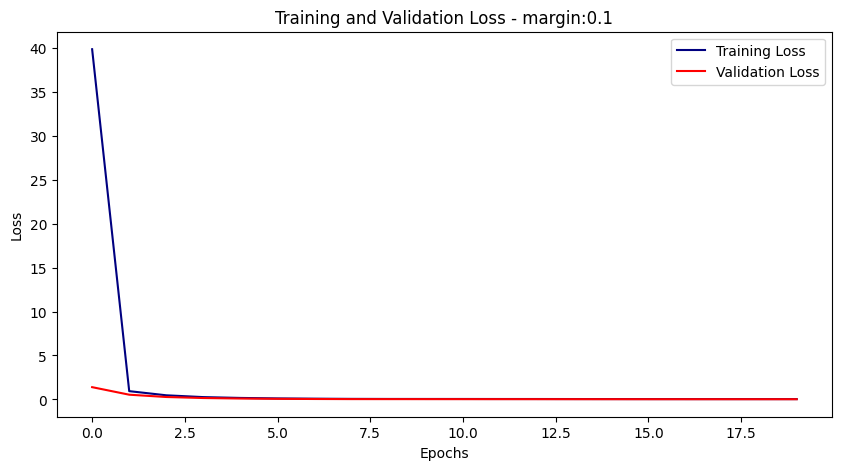

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss', color='navy')
plt.plot(val_loss, label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss - margin:0.1')
plt.legend()
plt.show()

### Roc

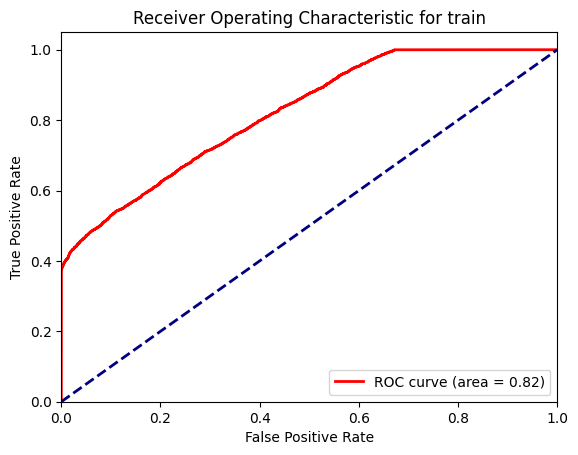

In [ ]:
train_fpr, train_tpr, train_thresholds = plot_roc_curve(model, train_loader, "train")

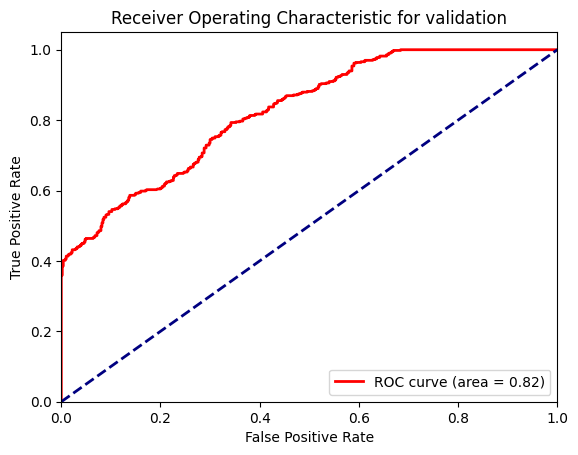

In [ ]:
val_fpr, val_tpr, val_thresholds = plot_roc_curve(model, val_loader, "validation")

####TPR

##### train

In [ ]:
thresholds = [0.5, 0.1, 0.01, 0.001]

# Report tpr for desired fpr values
for thr in thresholds:
    _fpr, idx = nearest_fnr(train_fpr, thr)
    _tpr = train_tpr[idx]
    print(f"Best False Negetive Rate(FPR) to {thr}: {_fpr:.4f}, True Positive Rate(FPR): {_tpr:.4f}")

Best False Negetive Rate(FPR) to 0.5: 0.5000, True Positive Rate(FPR): 0.8752
Best False Negetive Rate(FPR) to 0.1: 0.1000, True Positive Rate(FPR): 0.5282
Best False Negetive Rate(FPR) to 0.01: 0.0100, True Positive Rate(FPR): 0.4030
Best False Negetive Rate(FPR) to 0.001: 0.0010, True Positive Rate(FPR): 0.3785


##### validation

In [ ]:
thresholds = [0.5, 0.1, 0.01, 0.001]

# Report tpr for desired fpr values
for thr in thresholds:
    _fpr, idx = nearest_fnr(val_fpr, thr)
    _tpr = val_tpr[idx]
    print(f"Best False Negetive Rate(FPR) to {thr}: {_fpr:.4f}, True Positive Rate(FPR): {_tpr:.4f}")